In [1]:
# The code was removed by Watson Studio for sharing.

# IBM Data Science Professional Certificate
# Applied Data Science Capstone

# Finding optimal locations to open restaurant/grocery businesses.

<hr/>

## 1. Introduction
An international grocery and restaurant chain looking forward opening their business locations in the city of Toronto.  They wanted to identify optimum locations having maximum businesses potential and required to generate business intelligence to form a strategy in establishing their new business locations. 
In the week 3 assignment we note that the Toronto city has 140 postal zip codes assigned to 103 different boroughs. This project will conduct analyzing population demographics, financial and household data in those neighborhoods and cluster them based on their similarity. It will also find the existing venues creating competition (e.g. Restaurants, Grocery stores) and other venues in the proximity which adds new businesses opportunities.


## 2. Data

### Data Sources

#### Source #1: City of Toronto’s Open Data Catalogue
URL: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/
The data from Open Data Catalogue will be used to cluster neighborhoods based on their similarity characteristics. This will help the business to group neighborhoods when forming custom business strategies to their targeted neighborhoods. This data will also be used in finding the optimum business locations. 

#### Source #2: Datasets used in the Week3 Assignment, Neighborhood Segmentation and Clustering
This neighbourhood and postal codes dataset is created from Scraping Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. The above dataset is joined with the location dataset provided in the Week3 Assignment (https://cocl.us/Geospatial_data).

The above source had some gaps maping city-designated neighbourhoods in Toronto to the geo locations. Therfore, another webscraping atmmept were done across number of Wikipedia pages starting from https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto. The geo locations were extracted from each Neighbourhood's Wikipedia page and from few of them had to do manual data entry after reffering to other sources.

#### Source #3: Foursquare APIs location data
URL: https://developer.foursquare.com 
The foursquare dataset will be used to identify competitive business locations in each neighborhood (e.g. Grocery stores, restaurants) as well as venues which adds new businesses opportunities (e.g. Schools, Offices, Attractions, Shopping Malls, etc.).


### 2.1 Loading Datasets

In [2]:
import pandas as pd
import numpy as np

In [3]:
# The code was removed by Watson Studio for sharing.

#### Source1: Neighbourhood Profile Data

In [4]:
# The code was removed by Watson Studio for sharing.

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,...,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016",2731571.000,29113,23757,12054,30526,27695,...,16936,22156,53485,12541,7865,14349,11817,12528,27593,14804
3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011",2615060.000,30279,21988,11904,29177,26918,...,15004,21343,53350,11703,7826,13986,10578,11652,27713,14687
4,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,0.045,-0.039,0.08,0.013,0.046,0.029,...,0.129,0.038,0.003,0.072,0.005,0.026,0.117,0.075,-0.004,0.008


#### Source2: Geo Location Data

In [5]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
6,M6A,North York,Lawrence Heights,43.718518,-79.464763


#### Location Data From Web Scrapping

In [6]:
from bs4 import BeautifulSoup
import requests
import nltk
import re

In [7]:
designated_neighbourhoods = r'https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto'
source = requests.get(designated_neighbourhoods).text
soup = BeautifulSoup(source, 'lxml')
tableStr = soup.find('table').prettify() # Returns HTML table tag as a string
df = pd.read_html(tableStr, match='str', header=0) # Returns a list of dataframes from tables tags in the input string. header=0 is denote the first row conatins the column lables.
NeighbourhoodInfo = df[0] # First dataframe in the list
NeighbourhoodInfo.columns = ['NeighbourhoodId', 'Neighbourhood', 'Former city/borough', 'Neighbourhoods covered', 'Map']
NeighbourhoodInfo.drop(columns=['Map'], inplace=True)
NeighbourhoodInfo.head()

,NeighbourhoodId,Neighbourhood,Former city/borough,Neighbourhoods covered
0,129,Agincourt North,Scarborough,Agincourt and Brimwood
1,128,Agincourt South-Malvern West,Scarborough,Agincourt and Malvern
2,20,Alderwood,Etobicoke,Alderwood
3,95,Annex,Old City of Toronto,The Annex and Seaton Village
4,42,Banbury-Don Mills,North York,Don Mills


In [8]:
def GetCoordinates(Neigbourhood):
    targetPage = r'https://en.wikipedia.org/wiki/{}'.format(Neigbourhood)
    source = requests.get(targetPage).text
    soup = BeautifulSoup(source, 'lxml')
    text = soup.getText()
    try:
        coordinates = re.search(r'(\d{2}.\d{3,8})°N (\d{2}.\d{3,7})°W', text)
        Coordinate = (Neigbourhood, coordinates.group(1), coordinates.group(2))
    except:
        Coordinate = (Neigbourhood, 0, 0)
    return Coordinate

In [9]:
NeighbourhoodInfo['out'] = NeighbourhoodInfo.Neighbourhood.apply(GetCoordinates)
NeighbourhoodInfo[['tag','Latitude','Longitude']] = pd.DataFrame(NeighbourhoodInfo.out.values.tolist(), index= NeighbourhoodInfo.index)
NeighbourhoodInfo.drop(columns=['out','tag'], inplace=True)
NeighbourhoodInfo[['Longitude', 'Latitude']] = NeighbourhoodInfo[['Longitude', 'Latitude']].astype('float')
NeighbourhoodInfo['Longitude']=-NeighbourhoodInfo['Longitude']
NeighbourhoodInfo.sort_values('NeighbourhoodId')
NeighbourhoodInfo.loc[NeighbourhoodInfo.Neighbourhood=='Eglinton East','NeighbourhoodId']=138 # Data Error in Wikipedia
NeighbourhoodInfo.head()

,NeighbourhoodId,Neighbourhood,Former city/borough,Neighbourhoods covered,Latitude,Longitude
0,129,Agincourt North,Scarborough,Agincourt and Brimwood,43.79250,-79.28389
1,128,Agincourt South-Malvern West,Scarborough,Agincourt and Malvern,0.00000,-0.00000
2,20,Alderwood,Etobicoke,Alderwood,0.00000,-0.00000
3,95,Annex,Old City of Toronto,The Annex and Seaton Village,0.00000,-0.00000
4,42,Banbury-Don Mills,North York,Don Mills,43.73722,-79.34333


In [10]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,NeighbourhoodId,Designation,AlternateNeighbourhoodName,Latitude,Longitude,Former city/borough,Neighbourhoods covered
0,City of Toronto,0,NaN,Toronto,43.70000,-79.40000,NaN,NaN
1,West Humber-Clairville,1,No Designation,West Humber-Clairville,43.74200,-79.61700,Etobicoke,NaN
2,Mount Olive-Silverstone-Jamestown,2,NIA,Mount Olive-Silverstone-Jamestown,43.73972,-79.58028,Etobicoke,Smithfield
3,Thistletown-Beaumond Heights,3,NIA,Thistletown-Beaumond Heights,43.73722,-79.56528,Etobicoke,NaN
4,Rexdale-Kipling,4,No Designation,Rexdale-Kipling,43.72194,-79.57194,Etobicoke,Rexdale


## 2.2 Data Preperation

In [11]:
# Unique Data Categories
source1.Category.unique()

array(['Neighbourhood Information', 'Population',
       'Families, households and marital status', 'Language', 'Income',
       'Immigration and citizenship', 'Aboriginal peoples',
       'Visible minority', 'Ethnic origin', 'Housing', 'Education',
       'Labour', 'Journey to work', 'Language of work', 'Mobility'], dtype=object)

In [12]:
# List of columns in the dataset 
source1.columns

Index(['Category', 'Topic', 'Data Source', 'Characteristic', 'City of Toronto',
       'Agincourt North', 'Agincourt South-Malvern West', 'Alderwood', 'Annex',
       'Banbury-Don Mills',
       ...
       'Willowdale West', 'Willowridge-Martingrove-Richview', 'Woburn',
       'Woodbine Corridor', 'Woodbine-Lumsden', 'Wychwood', 'Yonge-Eglinton',
       'Yonge-St.Clair', 'York University Heights', 'Yorkdale-Glen Park'],
      dtype='object', length=145)

#### Create Neighbourhood List

In [13]:
NeighbourhoodList = list(source1.columns[4:].values)
NeighbourhoodInformation = source1[source1.Category=='Neighbourhood Information'][NeighbourhoodList].transpose()
NeighbourhoodInformation = NeighbourhoodInformation.reset_index()
NeighbourhoodInformation.columns = ['Neighbourhood', 'NeighbourhoodId', 'TSNS2020Designation']
NeighbourhoodInformation.loc[NeighbourhoodInformation.Neighbourhood=='City of Toronto', 'NeighbourhoodId'] = 0
NeighbourhoodInformation['NeighbourhoodId'] = NeighbourhoodInformation['NeighbourhoodId'].astype('int')
NeighbourhoodInformation.head()

,Neighbourhood,NeighbourhoodId,TSNS2020Designation
0,City of Toronto,0,NaN
1,Agincourt North,129,No Designation
2,Agincourt South-Malvern West,128,No Designation
3,Alderwood,20,No Designation
4,Annex,95,No Designation


In [14]:
NeighbourhoodInformation = NeighbourhoodInformation.merge(NeighbourhoodCoordinateInfo[['NeighbourhoodId',  'AlternateNeighbourhoodName', 'Latitude', 'Longitude', 'Former city/borough', 'Neighbourhoods covered']], on='NeighbourhoodId',how='left')
NeighbourhoodInformation.head()

,Neighbourhood,NeighbourhoodId,TSNS2020Designation,AlternateNeighbourhoodName,Latitude,Longitude,Former city/borough,Neighbourhoods covered
0,City of Toronto,0,NaN,Toronto,43.7000,-79.400000,NaN,NaN
1,Agincourt North,129,No Designation,Agincourt North,43.7925,-79.283890,Scarborough,Agincourt and Brimwood
2,Agincourt South-Malvern West,128,No Designation,Agincourt,43.7925,-79.283889,Scarborough,Agincourt and Malvern
3,Alderwood,20,No Designation,Alderwood,43.6075,-79.540280,Etobicoke,Alderwood
4,Annex,95,No Designation,The Annex,43.6700,-79.404000,Old City of Toronto,The Annex and Seaton Village


### Map view

In [15]:
!conda install -c conda-forge folium=0.5.0 --yes # install folium. Uncomment and run if not installed

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  53.61 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  28.41 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  30.13 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  39.46 MB/s


In [16]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Custom function to mark a set of location data on a Folium map

In [17]:
# Mark locations on map and returns a  "folium.folium.Map" object
def MarkLocationsOnMap(c_lat, c_lon, VenueData, kclusters, l_Latitude, l_Longitude, l_Name, l_Cluster, l_ClusterLabel, zoom= 10, color= None, map_clusters=None):
    
    if map_clusters ==None:
        map_clusters = folium.Map(location=[c_lat, c_lon], zoom_start=zoom)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i+x+(i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster, cluster_label in zip(VenueData[l_Latitude], VenueData[l_Longitude], VenueData[l_Name], VenueData[l_Cluster], VenueData[l_ClusterLabel]):
        label = folium.Popup(str(poi) + '  (' + str(cluster_label) + ')', parse_html=True)
        try:
            if color==None:
                colorx = rainbow[cluster-1]
                fill_colorx=rainbow[cluster-1]
            else:
                colorx = color
                fill_colorx = color
        except:
            colorx = '#000000'
            fill_colorx = '#FFFFFF'            
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colorx,
            fill=True,
            fill_color=fill_colorx,
            fill_opacity=0.6).add_to(map_clusters)
    
    return map_clusters

In [18]:
# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]
kclusters = 140 # Number of neighbourhoods

NeighbourhoodInformation['Latitude'], NeighbourhoodInformation['Longitude'], NeighbourhoodInformation['Neighbourhood'], NeighbourhoodInformation['NeighbourhoodId']

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 15, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId>0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 15, color= None, map_clusters=map_clustersx)

#### Extracting Neighbourhood data

In [19]:
# List of data records need to extract
SourseDataFields = ['Topic', 'Characteristic'] + NeighbourhoodList

In [20]:
def ExtractData(Source, Category, ColumnsList=None):
    DataSet = Source[Source.Category==Category][SourseDataFields].transpose()
    DataSet.columns = DataSet.loc['Characteristic']
    DataSet = DataSet.drop(index=['Topic', 'Characteristic'])
    if ColumnsList != None:
        DataSet = DataSet[ColumnsList]
    return DataSet

##### Population

In [21]:
Population_col=['Population, 2016', 'Total private dwellings', 'Population density per square kilometre', 'Land area in square kilometres']
AgeCategory_col = ['Children (0-14 years)', 'Youth (15-24 years)', 'Working Age (25-54 years)', 'Pre-retirement (55-64 years)', 'Seniors (65+ years)', 'Older Seniors (85+ years)']

ColumnsList = Population_col + AgeCategory_col
Population = ExtractData(source1, 'Population', ColumnsList)
Population.head()

Characteristic,"Population, 2016",Total private dwellings,Population density per square kilometre,Land area in square kilometres,Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),Pre-retirement (55-64 years),Seniors (65+ years),Older Seniors (85+ years)
City of Toronto,2.73157e+06,1.17906e+06,4334,630.2,398135,340270,1.22956e+06,336670,426945,66000
Agincourt North,29113,9371,3929,7.41,3840,3705,11305,4230,6045,925
Agincourt South-Malvern West,23757,8535,3034,7.83,3075,3360,9965,3265,4105,555
Alderwood,12054,4732,2435,4.95,1760,1235,5220,1825,2015,320
Annex,30526,18109,10863,2.81,2360,3750,15040,3480,5910,1040


##### Income

In [22]:
ColumnsList = ["  Number of total income recipients aged 15 years and over in private households", "Total income: Aggregate amount ($'000)", "  Average after-tax income of households in 2015 ($)"]
Income = ExtractData(source1, 'Income', ColumnsList)
Income.head()

Characteristic,Number of total income recipients aged 15 years and over in private households,Total income: Aggregate amount ($'000),Average after-tax income of households in 2015 ($)
City of Toronto,2.18703e+06,1.14321e+08,81495
Agincourt North,23620,714879,427037
Agincourt South-Malvern West,19295,616446,278390
Alderwood,9930,473038,168602
Annex,25680,2888507,792507


##### EthnicOrigin

In [23]:
ColumnsList = ['  North American Aboriginal origins', '  Other North American origins', '  European origins', '  Latin; Central and South American origins', '  African origins', '  Asian origins', '  Oceania origins']
EthnicOrigin = ExtractData(source1, 'Ethnic origin', ColumnsList)
EthnicOrigin.head()

Characteristic,North American Aboriginal origins,Other North American origins,European origins,Latin; Central and South American origins,African origins,Asian origins,Oceania origins
City of Toronto,35630,345710,1.28885e+06,113820,146875,1.07929e+06,5790
Agincourt North,40,1345,3055,470,535,24305,10
Agincourt South-Malvern West,105,1190,3770,480,625,17955,0
Alderwood,305,2355,9135,315,215,2055,0
Annex,475,5255,21055,765,1040,6485,140


##### Household

In [24]:
ColumnsList = [' Average household size', '  Married or living common law', 'Persons living alone (total)']
Household = ExtractData(source1, 'Families, households and marital status', ColumnsList)
Household.head()

Characteristic,Average household size,Married or living common law,Persons living alone (total)
City of Toronto,2.42,1.18136e+06,359955
Agincourt North,3.16,14200,1355
Agincourt South-Malvern West,2.88,11205,1625
Alderwood,2.6,5735,1105
Annex,1.8,12275,7880


##### Labour

In [25]:
ColumnsList = ['Employment rate']
Labour = ExtractData(source1, 'Labour', ColumnsList)
Labour.head()##### Population

Characteristic,Employment rate
City of Toronto,59.3
Agincourt North,50
Agincourt South-Malvern West,53.2
Alderwood,62.4
Annex,65.8


##### Safety

In [26]:
# The code was removed by Watson Studio for sharing.

In [27]:
Safety = pd.read_excel(streaming_body_1,sheet_name ='RawData-Ref Period 2011', header=1)
Safety = Safety.set_index('Neighbourhood Id')[['Total Major Crime Incidents', 'Break & Enters', 'Robberies', 'Thefts']]
Safety.head()

,Total Major Crime Incidents,Break & Enters,Robberies,Thefts
Neighbourhood Id,,,,
1,1119,175,82,54
2,690,61,78,7
3,192,36,17,2
4,164,32,16,3
5,185,25,23,19


##### Economics

In [28]:
# The code was removed by Watson Studio for sharing.

In [29]:
Economics = pd.read_excel(streaming_body_2,sheet_name ='RawData-Ref Period 2011', header=1)
Economics = Economics.set_index('Neighbourhood Id')[['Businesses', 'Debt Risk Score', 'Home Prices', 'Local Employment']]
Economics.head()

,Businesses,Debt Risk Score,Home Prices,Local Employment
Neighbourhood Id,,,,
1,2463,719,317508,58271
2,271,687,251119,3244
3,217,718,414216,1311
4,144,721,392271,1178
5,67,692,233832,903


##### Transportation

In [30]:
# The code was removed by Watson Studio for sharing.

In [31]:
Transportation = pd.read_excel(streaming_body_3,sheet_name ='RawData-Ref Period 2011', header=0)
Transportation = Transportation.set_index('Neighbourhood Id')[['TTC Stops']]
Transportation.head()

,TTC Stops
Neighbourhood Id,
1,338
2,70
3,45
4,40
5,29


### 2.3 Creating the Base Dataset to further analysis and modeling

In [32]:
DataCategories = ['Population', 'Income', 'EthnicOrigin', 'Household', 'Labour', 'Safety', 'Economics', 'Transportation']
PopulationVariables = list(Population.columns.values)
IncomeVariables = list(Income.columns.values)
EthnicOriginVariables = list(EthnicOrigin.columns.values)
HouseholdVariables = list(Household.columns.values)
LabourVariables = list(Labour.columns.values)
SafetyVariables = list(Safety.columns.values)
EconomicsVariables = list(Economics.columns.values)
TransportationVariables = list(Transportation.columns.values)

AllVariables = PopulationVariables+IncomeVariables+EthnicOriginVariables+HouseholdVariables+LabourVariables+SafetyVariables+EconomicsVariables+TransportationVariables

In [33]:
NeighbourhoodDataSet = NeighbourhoodInformation.merge(Population, left_on='Neighbourhood', right_index=True, how='left')
# Merge with rest of the data sets
NeighbourhoodDataSet = NeighbourhoodDataSet.merge(Income, left_on='Neighbourhood', right_index=True, how='left')
NeighbourhoodDataSet = NeighbourhoodDataSet.merge(EthnicOrigin, left_on='Neighbourhood', right_index=True, how='left')
NeighbourhoodDataSet = NeighbourhoodDataSet.merge(Household, left_on='Neighbourhood', right_index=True, how='left')
NeighbourhoodDataSet = NeighbourhoodDataSet.merge(Labour, left_on='Neighbourhood', right_index=True, how='left')

NeighbourhoodDataSet = NeighbourhoodDataSet.merge(Safety, left_on='NeighbourhoodId', right_index=True, how='left')
NeighbourhoodDataSet = NeighbourhoodDataSet.merge(Economics, left_on='NeighbourhoodId', right_index=True, how='left')
NeighbourhoodDataSet = NeighbourhoodDataSet.merge(Transportation, left_on='NeighbourhoodId', right_index=True, how='left')

In [34]:
#Convert all variables to numeric
NeighbourhoodDataSet[AllVariables] = NeighbourhoodDataSet[AllVariables].astype('float')


In [35]:
# Construct Combined Fields
NeighbourhoodDataSet['BreakEntersRobberiesThefts'] = NeighbourhoodDataSet['Break & Enters']+NeighbourhoodDataSet['Robberies']+NeighbourhoodDataSet['Thefts']
NeighbourhoodDataSet['BuisnessTargetPopulation'] = NeighbourhoodDataSet['Youth (15-24 years)']+NeighbourhoodDataSet['Working Age (25-54 years)']+NeighbourhoodDataSet['Pre-retirement (55-64 years)']
NeighbourhoodDataSet['Diversity'] = (NeighbourhoodDataSet['\xa0 European origins']+NeighbourhoodDataSet['\xa0 Latin; Central and South American origins']+NeighbourhoodDataSet['\xa0 African origins']+NeighbourhoodDataSet['\xa0 Asian origins']+NeighbourhoodDataSet['\xa0 Oceania origins']) / (NeighbourhoodDataSet['\xa0 North American Aboriginal origins']+NeighbourhoodDataSet['\xa0 Other North American origins'])

CombinedVariables = ['BreakEntersRobberiesThefts', 'BuisnessTargetPopulation', 'Diversity']

In [36]:
#Sperate city totals from Neighbourhood data
CityDataSet = NeighbourhoodDataSet[NeighbourhoodDataSet.NeighbourhoodId==0]
NeighbourhoodDataSet = NeighbourhoodDataSet[NeighbourhoodDataSet.NeighbourhoodId>0]

In [37]:
NeighbourhoodDataSet.head()

,Neighbourhood,NeighbourhoodId,TSNS2020Designation,AlternateNeighbourhoodName,Latitude,Longitude,Former city/borough,Neighbourhoods covered,"Population, 2016",Total private dwellings,...,Robberies,Thefts,Businesses,Debt Risk Score,Home Prices,Local Employment,TTC Stops,BreakEntersRobberiesThefts,BuisnessTargetPopulation,Diversity
1,Agincourt North,129,No Designation,Agincourt North,43.79250,-79.283890,Scarborough,Agincourt and Brimwood,29113.0,9371.0,...,54.0,4.0,353.0,765.0,375307.0,7449.0,94.0,163.0,19240.0,20.487365
2,Agincourt South-Malvern West,128,No Designation,Agincourt,43.79250,-79.283889,Scarborough,Agincourt and Malvern,23757.0,8535.0,...,44.0,5.0,1378.0,756.0,332710.0,18329.0,125.0,159.0,16590.0,17.629344
3,Alderwood,20,No Designation,Alderwood,43.60750,-79.540280,Etobicoke,Alderwood,12054.0,4732.0,...,12.0,4.0,309.0,764.0,504233.0,4839.0,60.0,93.0,8280.0,4.406015
4,Annex,95,No Designation,The Annex,43.67000,-79.404000,Old City of Toronto,The Annex and Seaton Village,30526.0,18109.0,...,38.0,20.0,2328.0,755.0,993491.0,25719.0,120.0,213.0,22270.0,5.145724
5,Banbury-Don Mills,42,No Designation,Banbury-Don Mills,43.73722,-79.343330,North York,Don Mills,27695.0,12473.0,...,10.0,23.0,834.0,776.0,613647.0,25614.0,128.0,121.0,17095.0,7.819364


In [38]:
CityDataSet.head()

,Neighbourhood,NeighbourhoodId,TSNS2020Designation,AlternateNeighbourhoodName,Latitude,Longitude,Former city/borough,Neighbourhoods covered,"Population, 2016",Total private dwellings,...,Robberies,Thefts,Businesses,Debt Risk Score,Home Prices,Local Employment,TTC Stops,BreakEntersRobberiesThefts,BuisnessTargetPopulation,Diversity
0,City of Toronto,0,NaN,Toronto,43.7,-79.4,NaN,NaN,2731571.0,1179057.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1906495.0,6.908861


#### Saving the dataset

In [39]:
# The code was removed by Watson Studio for sharing.

{'asset_id': '06701ac3-88d5-4daa-9c0d-0778bc99bb95',
 'bucket_name': 'courseracapstone-donotdelete-pr-gbfmxclrbbynhm',
 'file_name': 'NeighbourhoodDataSetToModel.csv',
 'message': 'File NeighbourhoodDataSetToModel.csv has been written successfully to the associated OS'}

<hr/>

### 2.4 Exploring the area using Foursquare API (Source3: Venue dataset)

In [40]:
import json
import requests 
from pandas.io.json import json_normalize

####  Four Squre Credentials and URL

In [41]:
# The code was removed by Watson Studio for sharing.

#### API Call returns JSON object resons : GetVenues(latitude, longitude, radius, limit, query)
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [42]:
# The code was removed by Watson Studio for sharing.

In [43]:
def GetCategories(categoriesJSON):
    try:
        category = json_normalize(categoriesJSON[0])
        category = category[category.primary==True]['shortName'].values[0]
    except:
        category = None
    return category

In [44]:
def GetVenuesData(NeighbourhoodId, latitude, longitude, radius, limit, query):
    print('Working on Neighbourhood {}'.format(NeighbourhoodId))
    results = GetVenues(latitude, longitude, radius, limit, query)
    venues = results['response']['groups'][0]['items']
    VenuesDataSet = json_normalize(venues) # fConvert JASON to Pandas dataframe
    try:
        VenuesDataSet['venue.category']=VenuesDataSet['venue.categories'].apply(GetCategories)
    except:
        VenuesDataSet['venue.category'] = None
    VenuesDataSet['NeighbourhoodId']=NeighbourhoodId
    VenuesDataSet['query']=query
    VenuesDataSet = VenuesDataSet.loc[:,VenuesDataSet.columns.isin(['NeighbourhoodId', 'query', 'venue.id', 'venue.name', 'venue.category', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode', 'venue.photos.count'])]
    return VenuesDataSet

In [45]:
# Test (Change format when needed)
query = 'Restaurant'

Neighbourhood = 'Broadview North'
d = NeighbourhoodDataSet[NeighbourhoodDataSet.Neighbourhood==Neighbourhood][['Neighbourhood', 'NeighbourhoodId', 'Latitude', 'Longitude', 'Land area in square kilometres']].values[0]
limit = 20
NeighbourhoodId = d[1]
latitude =  d[2]
longitude = d[3]
radius = np.sqrt(d[4]/np.pi)*1000 # Radius in meters approximated usin neighbourhood area
radius = int(np.ceil(radius/100)*100) 
print(NeighbourhoodId, latitude, longitude, radius, limit, query)
Restaurants = GetVenuesData(NeighbourhoodId, latitude, longitude, radius, limit, query)
Restaurants

57 43.693306 -79.31583 800 20 Restaurant
Working on Neighbourhood 57


,venue.id,venue.location.lat,venue.location.lng,venue.name,venue.photos.count,venue.category,NeighbourhoodId,query
0,4be2b4d3b02ec9b6fb6e4dc0,43.692151,-79.315767,Coffee Time,0,Café,57,Restaurant
1,4dbb444593a08f9274a06cda,43.693281,-79.315778,The Rib House,0,Diner,57,Restaurant
2,4c841690d92ea0930d355a72,43.692789,-79.315951,Thai Wok,0,Asian,57,Restaurant
3,4fa0570ae4b0badc8086c5bc,43.697228,-79.315287,East York Snack Bar,0,Snacks,57,Restaurant
4,4dbf46c41e72dd48b1ef56ef,43.693877,-79.310264,Oak Park Deli,0,Restaurant,57,Restaurant
5,4c44977c74ffc928ffc575cc,43.689695,-79.323629,Panzerotto Pizza,0,Pizza,57,Restaurant


#### Get data from venues of interest

##### Restaurant

##### Grocery Store

##### Fun

##### Shopping

##### Parking

##### Hotel

#### Combining Venue DataSets

#### Source3: Load pre extracted venue dataset
A previously extracted dataset using above mentioned codes were used in the daat analysis

In [46]:
# The code was removed by Watson Studio for sharing.

,NeighbourhoodId,query,venue.category,venue.id,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.name,venue.photos.count
0,129,Restaurant,Chinese,5aa5a8c85f68b930df32dc53,43.801909,-79.295409,M1W,Fishman Lobster Clubhouse Restaurant 魚樂軒,0.0
1,129,Restaurant,Asian,4bdda89c587b2d7fd88a5409,43.787048,-79.276658,M1S 2B7,One2 Snacks,0.0
2,129,Restaurant,Chinese,4b2d6bcaf964a5204ed624e3,43.784752,-79.277787,M1S 5H5,Maple Yip Seafood 陸羽海鮮酒家,0.0
3,129,Restaurant,Korean,4d2f8a98789a8cfa6b0826c6,43.786468,-79.275693,M1S 2B9,In Cheon House Korean & Japanese Restaurant 인천관,0.0
4,129,Restaurant,Caribbean,52d710b811d2a34615719f82,43.789660,-79.302340,NaN,Chris Jerk Caribbean Bistro,0.0


In [47]:
VenueDataSet = source3

In [48]:
VenueTypes = VenueDataSet['query'].unique()
VenueDataSet['VenueType']=None

for n in range(len(VenueTypes)):
    VenueDataSet.loc[VenueDataSet['query']==VenueTypes[n],'VenueType']= n+1

#VenueDataSet.loc[:,'VenueType'] = n+1
VenueDataSet.head()

,NeighbourhoodId,query,venue.category,venue.id,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.name,venue.photos.count,VenueType
0,129,Restaurant,Chinese,5aa5a8c85f68b930df32dc53,43.801909,-79.295409,M1W,Fishman Lobster Clubhouse Restaurant 魚樂軒,0.0,1
1,129,Restaurant,Asian,4bdda89c587b2d7fd88a5409,43.787048,-79.276658,M1S 2B7,One2 Snacks,0.0,1
2,129,Restaurant,Chinese,4b2d6bcaf964a5204ed624e3,43.784752,-79.277787,M1S 5H5,Maple Yip Seafood 陸羽海鮮酒家,0.0,1
3,129,Restaurant,Korean,4d2f8a98789a8cfa6b0826c6,43.786468,-79.275693,M1S 2B9,In Cheon House Korean & Japanese Restaurant 인천관,0.0,1
4,129,Restaurant,Caribbean,52d710b811d2a34615719f82,43.789660,-79.302340,NaN,Chris Jerk Caribbean Bistro,0.0,1


#### Mark Neighbourhood venues on the map

In [49]:
def MapNeighbourhood(SelectedNeighbourhoodId=None, SelectedNeighbourhoodName=None, NeighbourhoodDataSet=None, VenueDataSet=None, zoom= 10):
    if SelectedNeighbourhoodId != None:
        SelectedNeighbourhood = NeighbourhoodDataSet[NeighbourhoodDataSet.NeighbourhoodId== SelectedNeighbourhoodId]
    elif SelectedNeighbourhoodName != None:
        SelectedNeighbourhood = NeighbourhoodDataSet[NeighbourhoodDataSet.Neighbourhood== SelectedNeighbourhoodName]
    else:
        return None

    # Number of clusters
    kclusters = len(VenueDataSet['VenueType'].unique()) # Number of categories

    # Set map center to Toronto city center
    c_lat = SelectedNeighbourhood['Latitude'].values[0]
    c_lon = SelectedNeighbourhood['Longitude'].values[0]

    # Create the map plot
    zoom= zoom
    map_clusters_x = MarkLocationsOnMap(c_lat, c_lon, SelectedNeighbourhood, len(SelectedNeighbourhood.index), l_Latitude='Latitude', l_Longitude='Longitude', l_Name='Neighbourhood', l_Cluster='NeighbourhoodId', l_ClusterLabel='NeighbourhoodId', zoom= zoom, color='#000000')
    MarkLocationsOnMap(c_lat, c_lon, VenueDataSet[VenueDataSet.NeighbourhoodId==SelectedNeighbourhood.NeighbourhoodId.values[0]], kclusters, l_Latitude='venue.location.lat', l_Longitude='venue.location.lng', l_Name='venue.name', l_Cluster='VenueType', l_ClusterLabel='venue.category', zoom= zoom, map_clusters=map_clusters_x)
    
    return map_clusters_x

In [50]:
MapNeighbourhood(SelectedNeighbourhoodId=None, SelectedNeighbourhoodName='University', NeighbourhoodDataSet=NeighbourhoodDataSet, VenueDataSet=VenueDataSet, zoom= 15)

####  Counts of venues of interest by neighbourhood

In [51]:
VenuesCount = pd.pivot_table(VenueDataSet, index='NeighbourhoodId', columns='query', aggfunc='count', values='venue.id', margins=True)
VenuesCount = VenuesCount.fillna(0).astype('int')
VenueCountsVariables = list(VenuesCount.columns.values[:-1]) #Remove 'All'
VenuesCount.sort_values('All', ascending=False).head()

query,Fun,Grocery Store,Hotel,Parking,Restaurant,Shopping,All
NeighbourhoodId,,,,,,,
All,2097,547,250,360,4569,2093,9916
76,100,14,26,31,100,100,371
78,79,14,13,8,100,100,314
75,65,23,18,18,100,49,273
81,77,5,8,3,100,73,266


In [52]:
VenuesCount['SupportiveVenues'] = VenuesCount['Parking'] + VenuesCount['Shopping'] + VenuesCount['Fun'] + VenuesCount['Hotel']
VenuesCount['CompetitiveVenues'] =  VenuesCount['Grocery Store'] + VenuesCount['Restaurant']

CombinedVariables = CombinedVariables+['SupportiveVenues', 'CompetitiveVenues']

In [53]:
NeighbourhoodDataSetToModel = NeighbourhoodDataSet.merge(VenuesCount[VenuesCount.index!='All'].drop(columns='All'), left_on='NeighbourhoodId', right_index=True, how='left')
NeighbourhoodDataSetToModel.head()

,Neighbourhood,NeighbourhoodId,TSNS2020Designation,AlternateNeighbourhoodName,Latitude,Longitude,Former city/borough,Neighbourhoods covered,"Population, 2016",Total private dwellings,...,BuisnessTargetPopulation,Diversity,Fun,Grocery Store,Hotel,Parking,Restaurant,Shopping,SupportiveVenues,CompetitiveVenues
1,Agincourt North,129,No Designation,Agincourt North,43.79250,-79.283890,Scarborough,Agincourt and Brimwood,29113.0,9371.0,...,19240.0,20.487365,4,7,1,3,71,23,31,78
2,Agincourt South-Malvern West,128,No Designation,Agincourt,43.79250,-79.283889,Scarborough,Agincourt and Malvern,23757.0,8535.0,...,16590.0,17.629344,4,7,1,3,71,23,31,78
3,Alderwood,20,No Designation,Alderwood,43.60750,-79.540280,Etobicoke,Alderwood,12054.0,4732.0,...,8280.0,4.406015,4,3,3,2,20,9,18,23
4,Annex,95,No Designation,The Annex,43.67000,-79.404000,Old City of Toronto,The Annex and Seaton Village,30526.0,18109.0,...,22270.0,5.145724,64,13,6,4,100,66,140,113
5,Banbury-Don Mills,42,No Designation,Banbury-Don Mills,43.73722,-79.343330,North York,Don Mills,27695.0,12473.0,...,17095.0,7.819364,8,6,2,5,32,37,52,38


In [54]:
NeighbourhoodDataSetToModel['NeighbourhoodLabel'] = "["+ NeighbourhoodDataSetToModel['NeighbourhoodId'].astype('str')+"] "+NeighbourhoodDataSetToModel['Neighbourhood']
NeighbourhoodDataSetToModel.head()

,Neighbourhood,NeighbourhoodId,TSNS2020Designation,AlternateNeighbourhoodName,Latitude,Longitude,Former city/borough,Neighbourhoods covered,"Population, 2016",Total private dwellings,...,Diversity,Fun,Grocery Store,Hotel,Parking,Restaurant,Shopping,SupportiveVenues,CompetitiveVenues,NeighbourhoodLabel
1,Agincourt North,129,No Designation,Agincourt North,43.79250,-79.283890,Scarborough,Agincourt and Brimwood,29113.0,9371.0,...,20.487365,4,7,1,3,71,23,31,78,[129] Agincourt North
2,Agincourt South-Malvern West,128,No Designation,Agincourt,43.79250,-79.283889,Scarborough,Agincourt and Malvern,23757.0,8535.0,...,17.629344,4,7,1,3,71,23,31,78,[128] Agincourt South-Malvern West
3,Alderwood,20,No Designation,Alderwood,43.60750,-79.540280,Etobicoke,Alderwood,12054.0,4732.0,...,4.406015,4,3,3,2,20,9,18,23,[20] Alderwood
4,Annex,95,No Designation,The Annex,43.67000,-79.404000,Old City of Toronto,The Annex and Seaton Village,30526.0,18109.0,...,5.145724,64,13,6,4,100,66,140,113,[95] Annex
5,Banbury-Don Mills,42,No Designation,Banbury-Don Mills,43.73722,-79.343330,North York,Don Mills,27695.0,12473.0,...,7.819364,8,6,2,5,32,37,52,38,[42] Banbury-Don Mills


<hr/>

## 3. Exploratory Data Analysis

In [55]:
NeighbourhoodDataSetToModel_stat=NeighbourhoodDataSetToModel.describe()
NeighbourhoodDataSetToModel_stat

,Latitude,Longitude,"Population, 2016",Total private dwellings,Population density per square kilometre,Land area in square kilometres,Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),Pre-retirement (55-64 years),...,BuisnessTargetPopulation,Diversity,Fun,Grocery Store,Hotel,Parking,Restaurant,Shopping,SupportiveVenues,CompetitiveVenues
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,43.708042,-79.400312,19511.221429,8421.835714,6261.135714,4.501714,2843.964286,2430.928571,8783.678571,2404.464286,...,13619.071429,8.021361,14.978571,3.907143,1.785714,2.571429,32.635714,14.950000,34.285714,36.542857
std,0.051291,0.101631,10033.589222,5360.479324,4840.359075,4.544665,1546.225445,1457.994778,5423.203831,1161.127227,...,7633.346395,4.322196,19.015506,3.488721,3.302028,3.674025,27.269561,16.754394,37.792749,30.061417
min,43.591390,-79.617000,6577.000000,2796.000000,1040.000000,0.420000,565.000000,675.000000,2750.000000,650.000000,...,4490.000000,3.273572,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000,2.000000
25%,43.667750,-79.478000,12019.500000,5377.750000,3595.250000,1.852500,1695.000000,1428.750000,5465.000000,1591.250000,...,8417.500000,4.842002,5.000000,2.000000,0.000000,1.000000,10.000000,5.000000,13.000000,12.000000
50%,43.700000,-79.405335,16749.500000,6883.000000,5071.500000,3.275000,2405.000000,2100.000000,7475.000000,2025.000000,...,11492.500000,6.565353,7.000000,3.000000,1.000000,2.000000,23.500000,8.000000,20.000000,27.500000
75%,43.743869,-79.328785,23854.500000,10109.500000,7621.250000,5.382500,3567.500000,3022.500000,10588.750000,3078.750000,...,16822.500000,9.724468,15.000000,5.000000,2.000000,3.000000,49.000000,20.000000,37.250000,54.000000
max,43.825830,-79.134170,65913.000000,47209.000000,44321.000000,36.890000,9625.000000,7840.000000,45105.000000,6690.000000,...,57625.000000,26.538462,100.000000,23.000000,26.000000,31.000000,100.000000,100.000000,257.000000,123.000000


In [56]:
import matplotlib.pyplot as plt

In [57]:
DataFields = ['Land area in square kilometres', 'Population, 2016', 'Employment rate', 'Businesses','Debt Risk Score', 'Home Prices', 'Local Employment', '  Number of total income recipients aged 15 years and over in private households', "Total income: Aggregate amount ($'000)",  '  Average after-tax income of households in 2015 ($)', ' Average household size', 'Total Major Crime Incidents', 'BreakEntersRobberiesThefts', 
'\xa0 North American Aboriginal origins',  '\xa0 Other North American origins', '\xa0 European origins', '\xa0 Latin; Central and South American origins', '\xa0 African origins', '\xa0 Asian origins', '\xa0 Oceania origins']
X=7
Y=3
FigX=25 
FigY=25


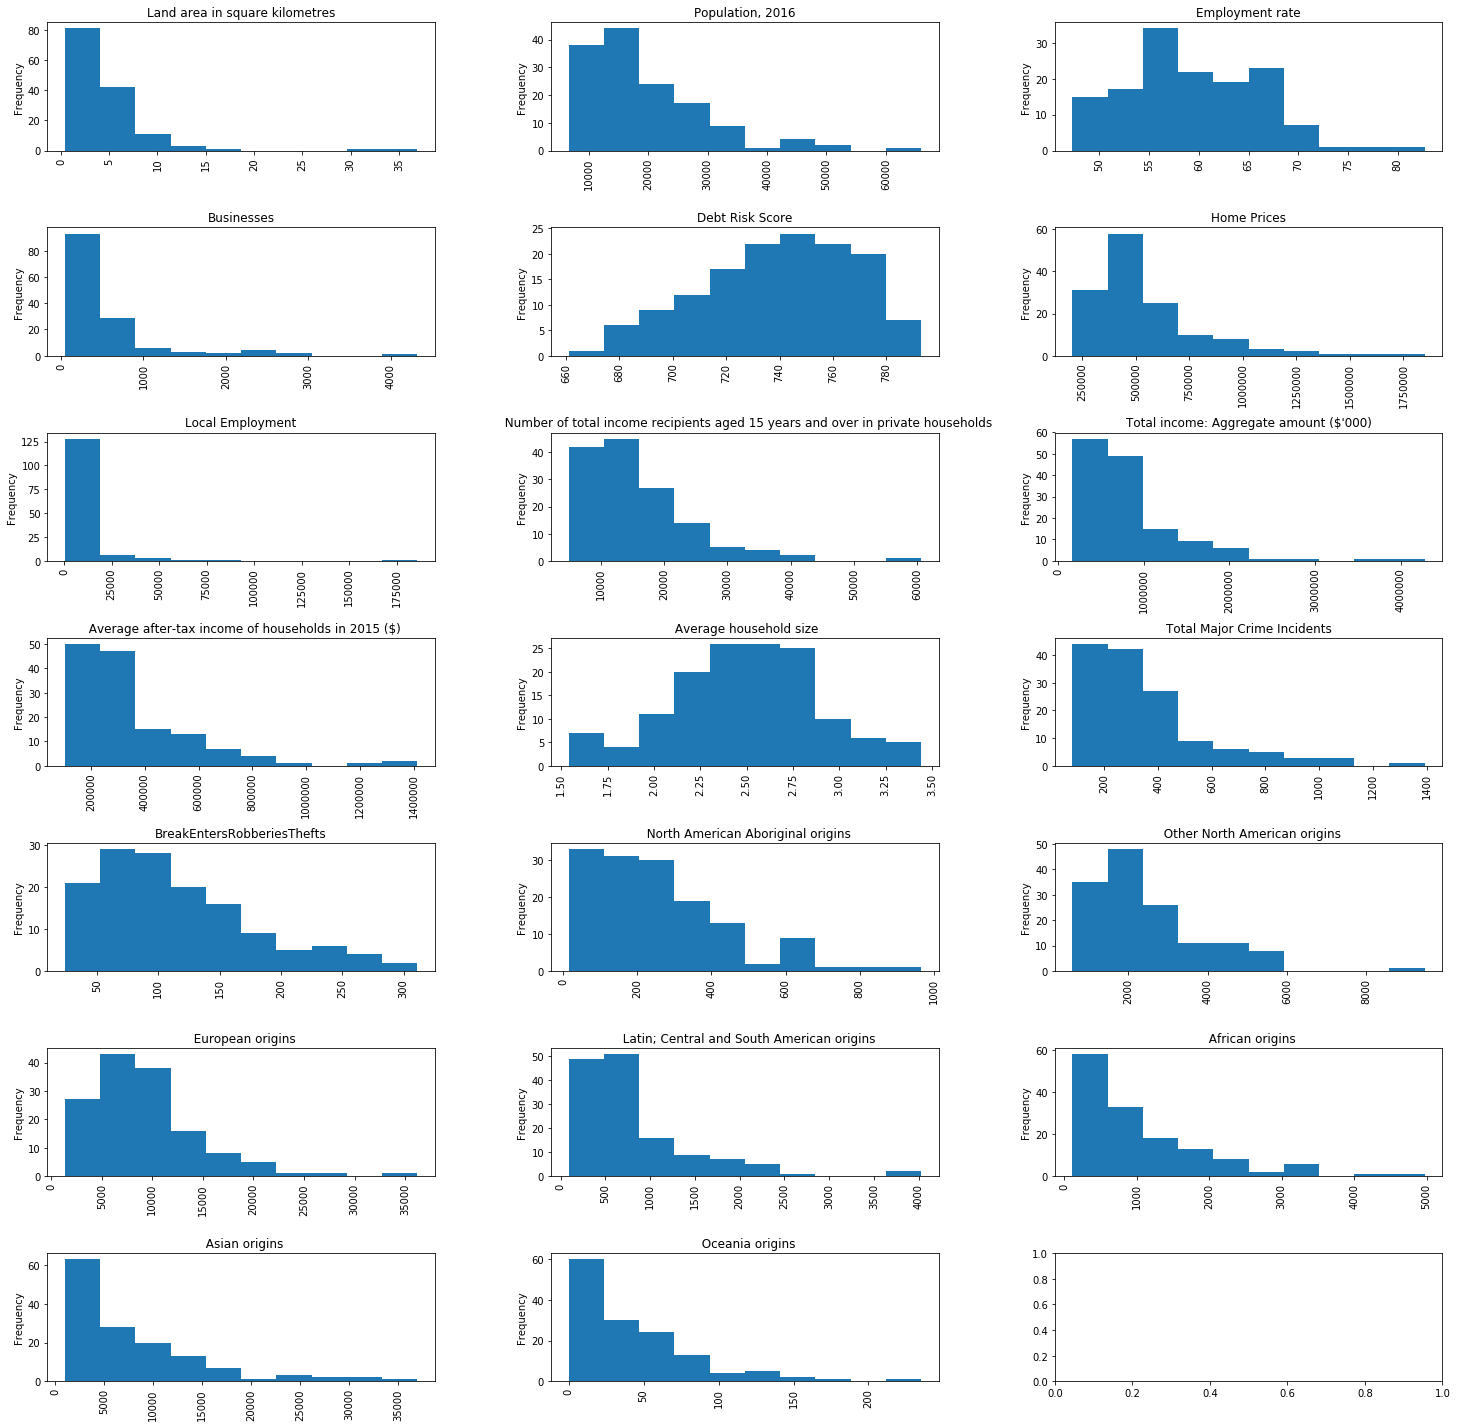

In [58]:
fig, axes = plt.subplots(X, Y,  figsize=(FigX, FigY))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

for i in range(X):
    for j in range(Y):        
        n = Y*i+j
        try:
            NeighbourhoodDataSetToModel[DataFields[n]].plot(kind='hist', rot=90, ax=axes[i,j]); axes[i,j].set_title(DataFields[n]);
        except:
            pass

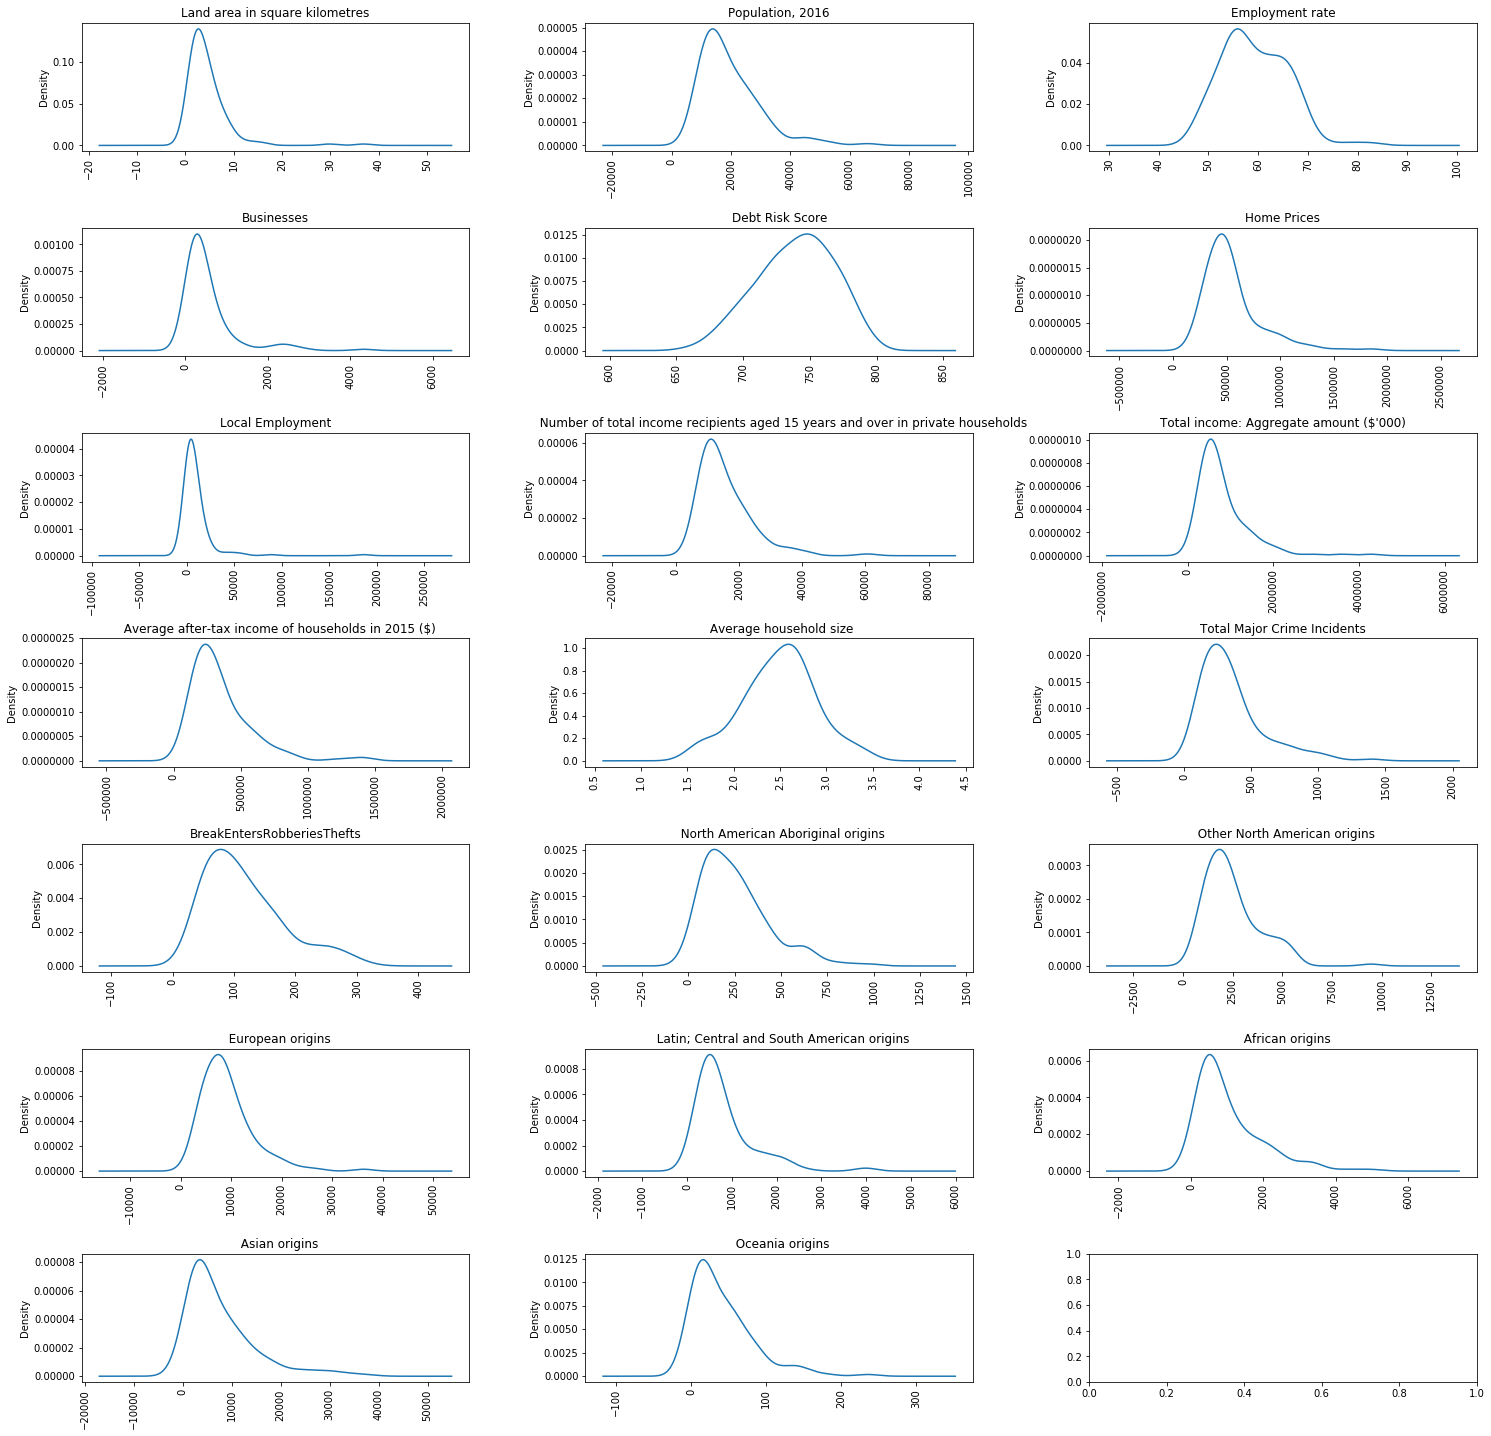

In [59]:
fig, axes = plt.subplots(X, Y,  figsize=(FigX, FigY))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

for i in range(X):
    for j in range(Y):        
        n = Y*i+j
        try:
            NeighbourhoodDataSetToModel[DataFields[n]].plot(kind='kde', rot=90, ax=axes[i,j]); axes[i,j].set_title(DataFields[n]);
        except:
            pass

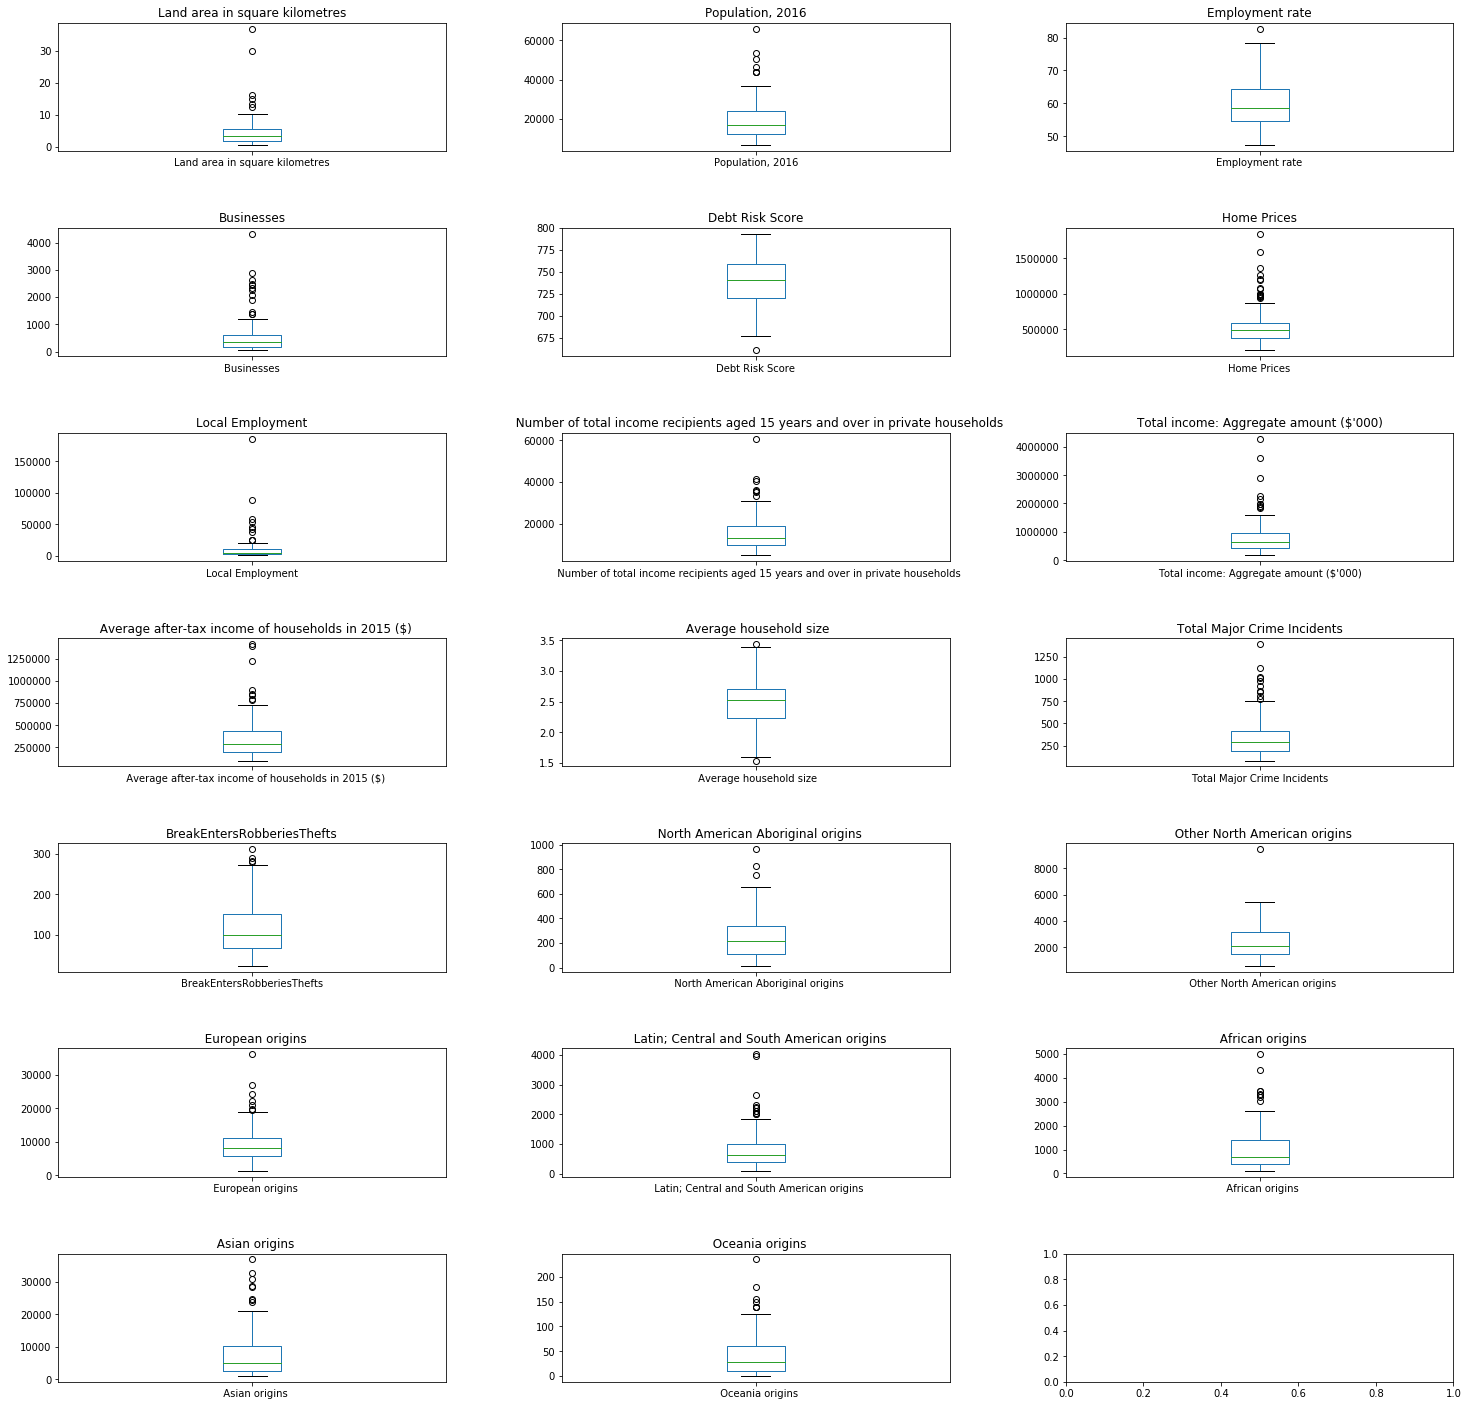

In [60]:
fig, axes = plt.subplots(X, Y,  figsize=(FigX, FigY))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

for i in range(X):
    for j in range(Y):        
        n = Y*i+j
        try:
            NeighbourhoodDataSetToModel[DataFields[n]].plot(kind='box', rot=0, ax=axes[i,j]); axes[i,j].set_title(DataFields[n]);
        except:
            pass

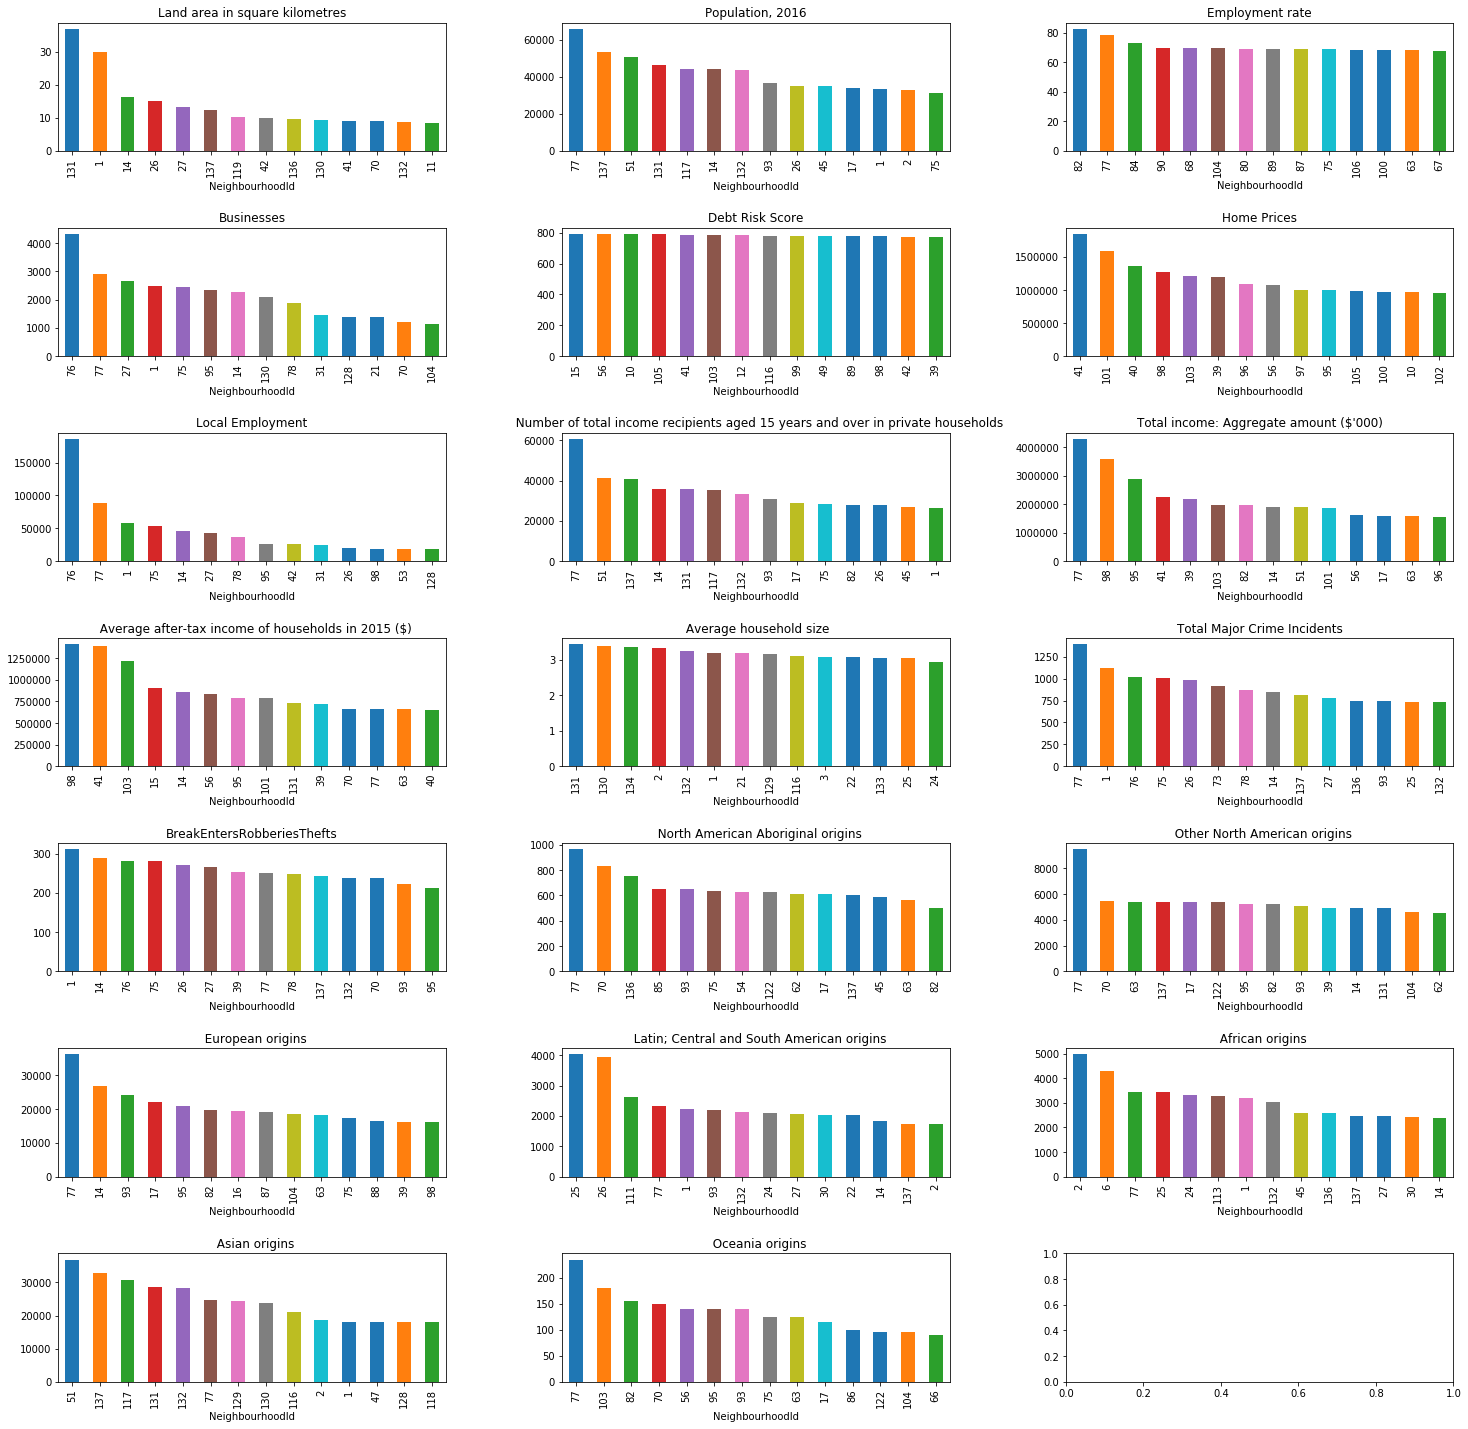

In [61]:
fig, axes = plt.subplots(X, Y,  figsize=(FigX, FigY))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

TopN = 14

for i in range(X):
    for j in range(Y):        
        n = Y*i+j
        try:
            NeighbourhoodDataSetToModel.sort_values(DataFields[n], ascending=False).head(TopN).plot(x='NeighbourhoodId', y=DataFields[n], kind='bar', legend=False, rot=90, ax=axes[i,j]); axes[i,j].set_title(DataFields[n]);
        except:
            pass

#### Distribution of Origins for selected neighbourhoods

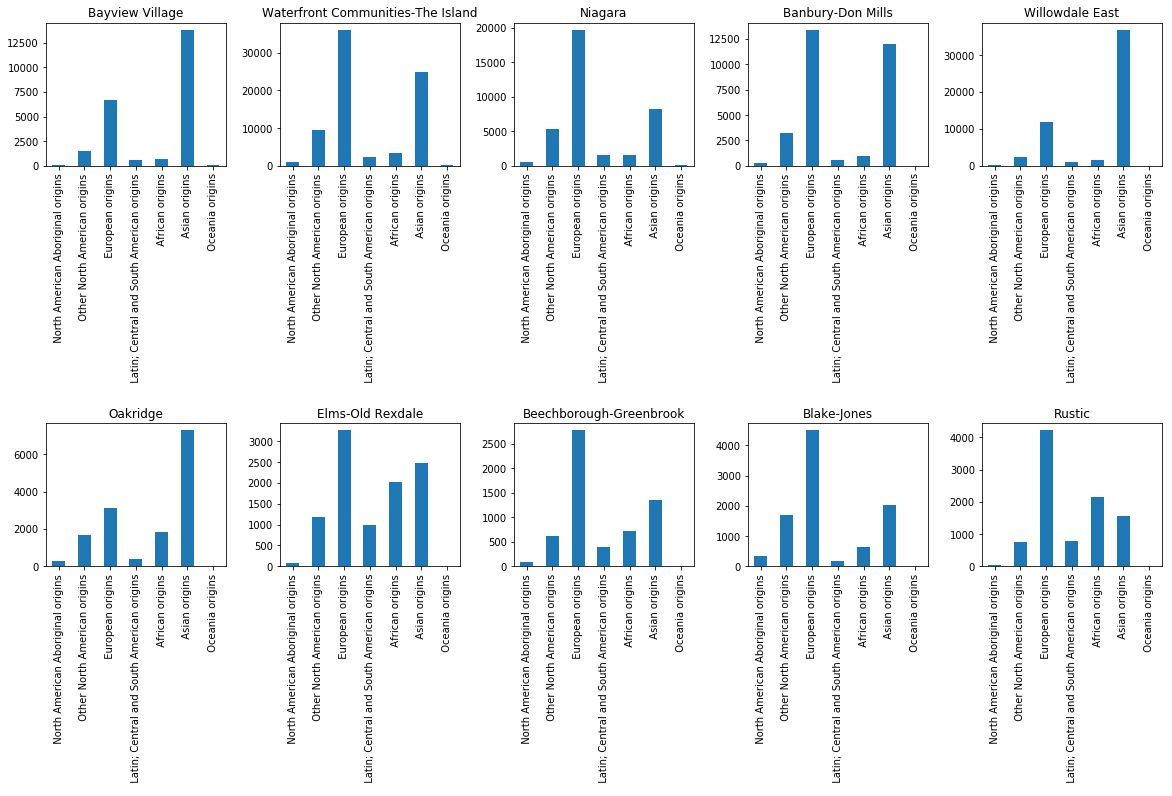

In [62]:
Neighbourhoods = ['Bayview Village', 'Waterfront Communities-The Island', 'Niagara', 'Banbury-Don Mills', 'Willowdale East'] + ['Oakridge', 'Elms-Old Rexdale', 'Beechborough-Greenbrook', 'Blake-Jones', 'Rustic']

X=2
Y=5
FigX = 20
FigY = 10

fig, axes = plt.subplots(X, Y,  figsize=(FigX, FigY))
plt.subplots_adjust(wspace=0.3, hspace=1.8)

for i in range(X):
    for j in range(Y):        
        n = Y*i+j
        #print(i, j , n)
        SelectedNeighbourhood = NeighbourhoodDataSetToModel[NeighbourhoodDataSetToModel.Neighbourhood==Neighbourhoods[n]][['\xa0 North American Aboriginal origins',  '\xa0 Other North American origins', '\xa0 European origins', '\xa0 Latin; Central and South American origins', '\xa0 African origins', '\xa0 Asian origins', '\xa0 Oceania origins']].transpose()
        SelectedNeighbourhood.plot(kind='bar', legend=False, rot=90, ax=axes[i,j]); axes[i,j].set_title(Neighbourhoods[n]);
        

#### Distribution of population by age for selected neighbourhoods

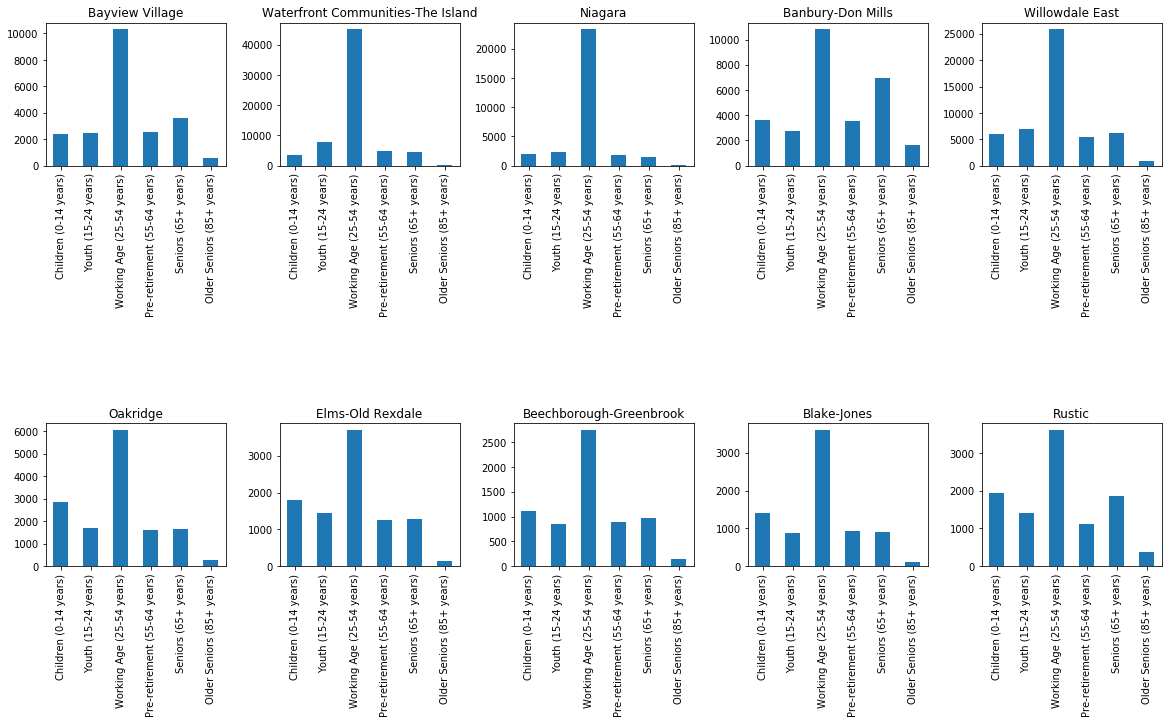

In [64]:
Neighbourhoods = ['Bayview Village', 'Waterfront Communities-The Island', 'Niagara', 'Banbury-Don Mills', 'Willowdale East'] + ['Oakridge', 'Elms-Old Rexdale', 'Beechborough-Greenbrook', 'Blake-Jones', 'Rustic']

X=2
Y=5
FigX = 20
FigY = 10

fig, axes = plt.subplots(X, Y,  figsize=(FigX, FigY))
plt.subplots_adjust(wspace=0.3, hspace=1.8)

for i in range(X):
    for j in range(Y):        
        n = Y*i+j
        #print(i, j , n)
        SelectedNeighbourhood = NeighbourhoodDataSetToModel[NeighbourhoodDataSetToModel.Neighbourhood==Neighbourhoods[n]][['Children (0-14 years)', 'Youth (15-24 years)', 'Working Age (25-54 years)', 'Pre-retirement (55-64 years)', 'Seniors (65+ years)', 'Older Seniors (85+ years)']
].transpose()
        SelectedNeighbourhood.plot(kind='bar', legend=False, rot=90, ax=axes[i,j]); axes[i,j].set_title(Neighbourhoods[n]);
        

## 4. Clustering Neighbourhoods

In [65]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

In [66]:
def ClusterNeighbourhoods(NeighbourhoodDataSetToModel, VariableList, ClusterColumn='Cluster Labels'):
    # set number of clusters
    kclusters = 5

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NeighbourhoodDataSetToModel[VariableList])

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 

    NeighbourhoodDataSetToModel[ClusterColumn] = kmeans.labels_
   
    return NeighbourhoodDataSetToModel

##### Cluster by: All variables

In [67]:
kclusters = 5

#Variable list
AllVariables = PopulationVariables + IncomeVariables + EthnicOriginVariables + HouseholdVariables + LabourVariables + SafetyVariables + EconomicsVariables + TransportationVariables + VenueCountsVariables + CombinedVariables

NeighbourhoodDataSetToModel_x = ClusterNeighbourhoods(NeighbourhoodDataSetToModel, AllVariables, ClusterColumn='Cluster Labels')

# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 10, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodDataSetToModel_x, kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'Cluster Labels', 'NeighbourhoodId', zoom= 10, color= None, map_clusters=map_clustersx)

#### Cluster 1 (Population)

In [68]:
kclusters = 5

#Variable list
AllVariables = ['Population, 2016', 'BuisnessTargetPopulation', 'Diversity',  'Population density per square kilometre', 'Total private dwellings', ' Average household size'] 

NeighbourhoodDataSetToModel_x = ClusterNeighbourhoods(NeighbourhoodDataSetToModel, AllVariables, ClusterColumn='Population_Cluster')

# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 10, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodDataSetToModel_x, kclusters, 'Latitude', 'Longitude', 'NeighbourhoodLabel', 'Population_Cluster', 'Population_Cluster', zoom= 10, color= None, map_clusters=map_clustersx)

#### Cluster 2 (Economy)

In [69]:
kclusters = 5

#Variable list
AllVariables = ['Employment rate', 'Businesses','Debt Risk Score', 'Home Prices', 'Local Employment', '  Number of total income recipients aged 15 years and over in private households', "Total income: Aggregate amount ($'000)",  '  Average after-tax income of households in 2015 ($)'] 

NeighbourhoodDataSetToModel_x = ClusterNeighbourhoods(NeighbourhoodDataSetToModel, AllVariables, ClusterColumn='Economy_Cluster')

# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 10, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodDataSetToModel_x, kclusters, 'Latitude', 'Longitude', 'NeighbourhoodLabel', 'Economy_Cluster', 'Economy_Cluster', zoom= 10, color= None, map_clusters=map_clustersx)

#### Cluster 3 (Locality)

In [70]:
kclusters = 5

#Variable list
AllVariables = ['Population density per square kilometre', 'Land area in square kilometres', 'Businesses', 'TTC Stops', 'SupportiveVenues', 'CompetitiveVenues', 'Grocery Store', 'Restaurant', 'Diversity'] 

NeighbourhoodDataSetToModel_x = ClusterNeighbourhoods(NeighbourhoodDataSetToModel, AllVariables, ClusterColumn='Locality_Cluster')

# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 10, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodDataSetToModel_x, kclusters, 'Latitude', 'Longitude', 'NeighbourhoodLabel', 'Locality_Cluster', 'Locality_Cluster', zoom= 10, color= None, map_clusters=map_clustersx)

#### Cluster 4 (Safty)

In [71]:
kclusters = 5

#Variable list
AllVariables = [ 'Total Major Crime Incidents',  'Break & Enters',  'Robberies',  'Thefts', 'BreakEntersRobberiesThefts'] 

NeighbourhoodDataSetToModel_x = ClusterNeighbourhoods(NeighbourhoodDataSetToModel, AllVariables, ClusterColumn='Safty_Cluster')

# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 10, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodDataSetToModel_x, kclusters, 'Latitude', 'Longitude', 'NeighbourhoodLabel', 'Safty_Cluster', 'Safty_Cluster', zoom= 10, color= None, map_clusters=map_clustersx)

In [72]:
AllVariables

['Total Major Crime Incidents',
 'Break & Enters',
 'Robberies',
 'Thefts',
 'BreakEntersRobberiesThefts']

##### Cluster by: SafetyVariables + EconomicsVariables + TransportationVariables + VenueCountsVariables

In [73]:
kclusters = 5

AllVariables = SafetyVariables + EconomicsVariables + TransportationVariables + VenueCountsVariables

NeighbourhoodDataSetToModel_x = ClusterNeighbourhoods(NeighbourhoodDataSetToModel, AllVariables, ClusterColumn='Cluster Labels')

# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 10, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodDataSetToModel_x, kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'Cluster Labels', 'NeighbourhoodId', zoom= 10, color= None, map_clusters=map_clustersx)

## 5. Rank Neighbourhoods

In [74]:
def RankDataSet(NeighbourhoodDataSetToModel, RankVariables):
    for var in RankVariables:
        NeighbourhoodDataSetToModel['Rank_{}'.format(var)] = NeighbourhoodDataSetToModel[var].rank(ascending=False).astype('int')
    return NeighbourhoodDataSetToModel

In [75]:
AllVariables = PopulationVariables + IncomeVariables + EthnicOriginVariables + HouseholdVariables + LabourVariables + SafetyVariables + EconomicsVariables + TransportationVariables + VenueCountsVariables + CombinedVariables
RankVariablesPositive = ['Population, 2016', 'BuisnessTargetPopulation', 'Diversity', 'SupportiveVenues', '  Average after-tax income of households in 2015 ($)', ' Average household size', 'Debt Risk Score',  'Employment rate', 'Local Employment', 'Businesses', '  Married or living common law', 'Persons living alone (total)']
RankVariablesNegative = ['CompetitiveVenues', 'Home Prices', 'BreakEntersRobberiesThefts', 'Total Major Crime Incidents']
RankVariablesUnsure = ['Grocery Store', 'Restaurant']
RankVariables = RankVariablesPositive + RankVariablesNegative + RankVariablesUnsure

In [76]:
NeighbourhoodDataSetToModel_Ranked = RankDataSet(NeighbourhoodDataSetToModel, RankVariables)

In [77]:
NeighbourhoodDataSetToModel_Ranked['Score'] = NeighbourhoodDataSetToModel_Ranked[['{}_{}'.format(a, b) for b in RankVariablesPositive for a in ['Rank']]].sum(axis=1) - \
NeighbourhoodDataSetToModel_Ranked[['{}_{}'.format(a, b) for b in RankVariablesNegative for a in ['Rank']]].sum(axis=1)*2

In [78]:
#NeighbourhoodDataSetToModel_Ranked[['Neighbourhood', 'NeighbourhoodId', 'Population, 2016', 'Rank_Population, 2016']]
NeighbourhoodDataSetToModel_Ranked['Rank'] = NeighbourhoodDataSetToModel_Ranked['Score'].rank(ascending=True).astype('int')
NeighbourhoodDataSetToModel_Ranked[['Neighbourhood', 'NeighbourhoodId', 'Population, 2016', 'Score', 'Rank']].sort_values(by=['Rank']).head()

,Neighbourhood,NeighbourhoodId,"Population, 2016",Score,Rank
49,Henry Farm,53,15723.0,-177,1
8,Bayview Village,52,21396.0,-177,1
119,Thorncliffe Park,55,21108.0,-86,3
88,Niagara,82,31180.0,-50,4
5,Banbury-Don Mills,42,27695.0,1,5


In [79]:
NeighbourhoodDataSetToModel_Ranked[['Neighbourhood', 'NeighbourhoodId', 'Population, 2016', 'Score', 'Rank']].sort_values(by=['Rank']).tail()

,Neighbourhood,NeighbourhoodId,"Population, 2016",Score,Rank
85,New Toronto,18,11463.0,596,136
35,Dufferin Grove,83,11785.0,609,137
121,University,79,7607.0,626,138
108,Rustic,28,9941.0,648,139
15,Blake-Jones,69,7727.0,667,140


In [80]:
kclusters = 140

# Set map center to Toronto city center
c_lat = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Latitude'].values[0]
c_lon = NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0]['Longitude'].values[0]

map_clustersx= MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodInformation[NeighbourhoodInformation.NeighbourhoodId==0], kclusters, 'Latitude', 'Longitude', 'Neighbourhood', 'NeighbourhoodId', 'NeighbourhoodId', zoom= 10, color= '#000000', map_clusters=None)
MarkLocationsOnMap(c_lat, c_lon, NeighbourhoodDataSetToModel_Ranked, kclusters, 'Latitude', 'Longitude', 'NeighbourhoodLabel', 'Rank', 'Rank', zoom= 10, color= None, map_clusters=map_clustersx)

## 6. Explore High Ranked Neighbourhoods

In [81]:
# Bayview Village
MapNeighbourhood(SelectedNeighbourhoodId=52, SelectedNeighbourhoodName=None, NeighbourhoodDataSet=NeighbourhoodDataSet, VenueDataSet=VenueDataSet, zoom= 15)

In [82]:
# Henry Farm
MapNeighbourhood(SelectedNeighbourhoodId=53, SelectedNeighbourhoodName=None, NeighbourhoodDataSet=NeighbourhoodDataSet, VenueDataSet=VenueDataSet, zoom= 15)

In [83]:
#88	Niagara
MapNeighbourhood(SelectedNeighbourhoodId=88, SelectedNeighbourhoodName=None, NeighbourhoodDataSet=NeighbourhoodDataSet, VenueDataSet=VenueDataSet, zoom= 15)

In [84]:
#Blake-Jones	
MapNeighbourhood(SelectedNeighbourhoodId=69, SelectedNeighbourhoodName=None, NeighbourhoodDataSet=NeighbourhoodDataSet, VenueDataSet=VenueDataSet, zoom= 15)

<hr/>

<i>This notebook is created by Sumudu Tennakoon  <a href='https://github.com/sptennak/Coursera_Capstone'>[GitHub Link]</a> </i>

<i> Last Update: 2018-01-01 </i>

Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/